#Load Dataset

In [26]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
import pandas as pd
import opendatasets as od

In [28]:
od.download(
    "https://www.kaggle.com/datasets/willarevalo/chexpert-v10-small")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aggelikidimitriou
Your Kaggle Key: ··········


100%|██████████| 10.7G/10.7G [01:31<00:00, 125MB/s]


In [29]:
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
import numpy as np
from collections import Counter
from skimage.transform import resize
from tqdm import tqdm

In [30]:
from pandas.core.common import random_state
class DataLoader:
  def __init__(self, data_path, sample_perc, val_perc):
    self.data_path = Path(data_path)
    self.full_df, self.full_train_df, self.full_valid_df = self.load_data()

    self.train_df, self.val_df, self.test_df = self.sample_dataset(sample_perc, val_perc)

  def image_to_vector(self, df):
    paths =  df.Path
    imgs = []
    for i in tqdm(paths):
      img = cv2.imread(os.path.join(self.data_path, i))
      img_rescaled = resize(img, (90,90,1), anti_aliasing=True)
      imgs.append(np.array(img_rescaled))

    flat_dims = 90*90
    data = np.array(imgs)
    data = data.reshape((data.shape[0], flat_dims))
    return data

  def feature_string(self, row):
    u_one_features = ['Atelectasis', 'Edema']
    u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
    feature_list = []
    for feature in u_one_features:
        if row[feature] in [-1,1]:
            feature_list.append(feature)
            
    for feature in u_zero_features:
        if row[feature] == 1:
            feature_list.append(feature)
            
    return ';'.join(feature_list)

  def load_data(self):
    full_train_df = pd.read_csv(self.data_path/'CheXpert-v1.0-small/train.csv')
    full_valid_df = pd.read_csv(self.data_path/'CheXpert-v1.0-small/valid.csv')

    full_train_df['train_valid'] = False
    full_valid_df['train_valid'] = True

    full_train_df['patient'] = full_train_df.Path.str.split('/',3,True)[2]
    full_train_df  ['study'] = full_train_df.Path.str.split('/',4,True)[3]

    full_valid_df['patient'] = full_valid_df.Path.str.split('/',3,True)[2]
    full_valid_df  ['study'] = full_valid_df.Path.str.split('/',4,True)[3]

    full_df = pd.concat([full_train_df, full_valid_df])

    full_df['feature_string'] = full_df.apply(self.feature_string,axis = 1).fillna('')
    full_df['feature_string'] = full_df['feature_string'] .apply(lambda x:x.split(";"))

    u_one_features = ['Atelectasis', 'Edema']
    u_zero_features = ['Cardiomegaly', 'Consolidation', 'Pleural Effusion']
    for target in u_one_features:
      full_df[target] = full_df[target].apply(lambda x: 1 if x in [-1, 1] else 0)
    
    for target in u_zero_features:
      full_df[target] = full_df[target].apply(lambda x: 1 if x == 1 else 0)
    
    return full_df, full_train_df, full_valid_df

  def sample_dataset(self, sample_perc = 0.00, val_perc = 0.1):
    train_only_df = self.full_df[~self.full_df.train_valid]
    valid_only_df = self.full_df[self.full_df.train_valid]

    unique_patients = train_only_df.patient.unique()
    np.random.seed(42)
    mask = np.random.rand(len(unique_patients)) <= sample_perc
    sample_patients = unique_patients[mask]

    # dev_df = train_only_df[self.full_train_df.patient.isin(sample_patients)]
    train_df = train_only_df[~self.full_train_df.patient.isin(sample_patients)]

    val_final = train_df.sample(frac = val_perc, random_state = 42)
    train_final = train_df.drop(val_final.index)
    test_final = valid_only_df

    return train_final, val_final, test_final

  def print_sample(self):
    #get the first 5 images

    paths =  list(self.full_df.Path)[45:50]
    labels = list(self.full_df.feature_string)[45:50]

    fig, m_axs = plt.subplots(1, len(labels), figsize = (20, 10))
    #show the images and label them
    for ii, c_ax in enumerate(m_axs):
        c_ax.imshow(cv2.imread(os.path.join(self.data_path,paths[ii])))
        c_ax.set_title(labels[ii])
        c_ax.axis('off')

  def print_class_stats(self):
    chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
    labels_count = Counter(label for chexpert_targets in self.full_df['feature_string'] for label in chexpert_targets)
    #plt.bar(chexpert_targets, labels_count.values(), align='center', alpha=0.5)
    #plt.show
    x_pos = np.arange(len(labels_count.values()))
    #Plot the data:
    my_colors = ["red","green","blue","orange","yellow","magenta","cyan"]
    lbls = list.copy(chexpert_targets)
    lbls.insert(0,'Nothing')
    plt.bar(x_pos, labels_count.values(), align='center', alpha=0.5 , color=my_colors)
    plt.xticks(x_pos, lbls, rotation='vertical')
    plt.axis('off')

In [31]:
chexpert = DataLoader('/content/chexpert-v10-small', 0.85, 0.1)

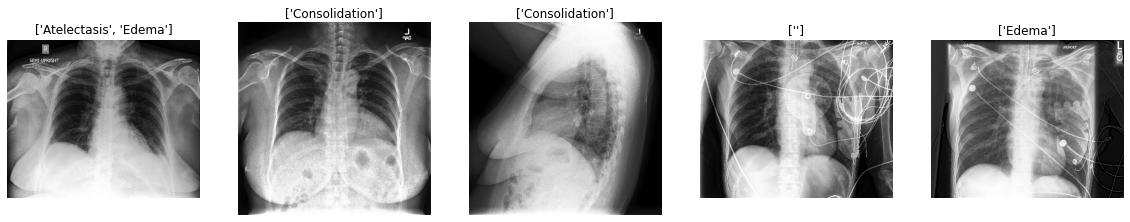

In [ ]:
chexpert.print_sample()

In [ ]:
chexpert.full_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,train_valid,patient,study,feature_string
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,0,NaN,NaN,...,0,0.0,0,NaN,NaN,1.0,False,patient00001,study1,[]
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,0,1.0,NaN,...,1,NaN,0,NaN,1.0,NaN,False,patient00002,study2,"[Atelectasis, Edema]"
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,0,1.0,NaN,...,0,NaN,0,NaN,1.0,NaN,False,patient00002,study1,[]
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,0,1.0,NaN,...,0,NaN,0,NaN,1.0,NaN,False,patient00002,study1,[]
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,0,NaN,NaN,...,0,0.0,0,NaN,NaN,NaN,False,patient00003,study1,[Edema]


In [ ]:
print('Train dataset shape: {}'.format(chexpert.train_df.shape))
print('Validation dataset shape: {}'.format(chexpert.val_df.shape))
print('Test dataset shape: {}'.format(chexpert.test_df.shape))

Train dataset shape: (29473, 23)
Validation dataset shape: (3275, 23)
Test dataset shape: (234, 23)


The size of the images is variable and very large. We have already sampled the dataset, but in order to use flattened image vectors for multilabel classification with classic algorithms, we need to further rescale them. 

All images will be rescaled to dimensions of 90*90*1. 

In [ ]:
cv2.imread(os.path.join(chexpert.data_path, chexpert.train_df.Path[4143])).shape

(390, 320, 3)

In [ ]:
X_train = chexpert.image_to_vector( chexpert.train_df)
X_val = chexpert.image_to_vector( chexpert.val_df)
X_test = chexpert.image_to_vector( chexpert.test_df)

Save train, validation and test sets as pickle files because conversion takes about 15 minutes.

In [ ]:
import pickle as pkl
pkl.dump(X_train, open('x_train_chex.pkl', 'wb'))
pkl.dump(X_val, open('x_val_chex.pkl', 'wb'))
pkl.dump(X_test, open('x_test_chex.pkl', 'wb'))

#Multilabel Classification

In [32]:
cd drive/MyDrive

/content/drive/MyDrive


In [33]:
import pickle as pkl
X_train = pkl.load(open('x_train_chex.pkl', 'rb'))
X_val = pkl.load(open('x_val_chex.pkl', 'rb'))
X_test = pkl.load(open('x_test_chex.pkl', 'rb'))

In [ ]:
dna_unoptimized_auc = {}

In [ ]:
unoptimized_predict_times = {}
unoptimized_fit_times = {}

In [34]:
from sklearn.metrics import roc_auc_score

In [35]:
Y_train = chexpert.train_df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']]
Y_val = chexpert.val_df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']]
Y_test = chexpert.test_df[['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']]

##Out of the box performance

Try some common classification algorithms which normally work on tabular data. Observe their out of the box performance.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier

#define Dummy
mfdummy = OneVsRestClassifier(DummyClassifier(strategy="most_frequent"))

#define GNB
gnb = OneVsRestClassifier(GaussianNB())

#define KNN
knn = OneVsRestClassifier(KNeighborsClassifier())

#define LR
logisticRegr = OneVsRestClassifier(LogisticRegression(max_iter=300))

#define MLP
mlp = OneVsRestClassifier(MLPClassifier())

classifiers = [mfdummy, gnb, knn, logisticRegr, mlp]
classifier_names = ['Most Frequent Dummy', 'Gaussian Naive Bayes', 'KNN', 'Logistic Regression', 'MLP']

In [ ]:
chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

In [ ]:
import time 

for i in tqdm(range(4)):
  clf = classifiers[i]
  clf_name = classifier_names[i]

  unoptimized_fit_times[clf_name] = {}
  unoptimized_predict_times[clf_name] = {}
  dna_unoptimized_auc[clf_name] = {}
  
  #fit classifiers and find scores 
  start_time = time.time()
  model = clf.fit(X_train, Y_train)
  unoptimized_fit_times[clf_name] =  time.time() - start_time

  start_time = time.time()
  pred = clf.predict(X_test)
  unoptimized_predict_times[clf_name] =  time.time() - start_time
   
  print()

  for i in range(5):
    dna_unoptimized_auc[clf_name][chexpert_targets[i]] = roc_auc_score(Y_test[chexpert_targets[i]], pred[:,i])
    print('AUC {} {} : {}'.format(clf_name, chexpert_targets[i], dna_unoptimized_auc[clf_name][chexpert_targets[i]]))

  print()


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: `n_features_in_` is deprecated in 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)



AUC Most Frequent Dummy Atelectasis : 0.5
AUC Most Frequent Dummy Cardiomegaly : 0.5
AUC Most Frequent Dummy Consolidation : 0.5
AUC Most Frequent Dummy Edema : 0.5
AUC Most Frequent Dummy Pleural Effusion : 0.5



 50%|█████     | 2/4 [00:22<00:22, 11.44s/it]


AUC Gaussian Naive Bayes Atelectasis : 0.649512987012987
AUC Gaussian Naive Bayes Cardiomegaly : 0.6618532955350815
AUC Gaussian Naive Bayes Consolidation : 0.7071460877431027
AUC Gaussian Naive Bayes Edema : 0.6301587301587301
AUC Gaussian Naive Bayes Pleural Effusion : 0.7098489587988204



 75%|███████▌  | 3/4 [00:57<00:21, 21.25s/it]


AUC KNN Atelectasis : 0.5370941558441558
AUC KNN Cardiomegaly : 0.5160347271438696
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6481481481481481
AUC KNN Pleural Effusion : 0.6294575029046384



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che


AUC Logistic Regression Atelectasis : 0.492288961038961
AUC Logistic Regression Cardiomegaly : 0.5056697377746279
AUC Logistic Regression Consolidation : 0.5
AUC Logistic Regression Edema : 0.5947089947089947
AUC Logistic Regression Pleural Effusion : 0.6011707927428724



In [ ]:
dna_unoptimized_auc

{'KNN': {'Atelectasis': 0.5370941558441558,
  'Cardiomegaly': 0.5160347271438696,
  'Consolidation': 0.5,
  'Edema': 0.6481481481481481,
  'Pleural Effusion': 0.6294575029046384},
 'Logistic Regression': {'Atelectasis': 0.492288961038961,
  'Cardiomegaly': 0.5056697377746279,
  'Consolidation': 0.5,
  'Edema': 0.5947089947089947,
  'Pleural Effusion': 0.6011707927428724},
 'MLP': {'Atelectasis': 0.49,
  'Cardiomegaly': 0.5,
  'Consolidation': 0.49,
  'Edema': 0.54,
  'Pleural Effusion': 0.58},
 'Most Frequent Dummy': {'Atelectasis': 0.5,
  'Cardiomegaly': 0.5,
  'Consolidation': 0.5,
  'Edema': 0.5,
  'Pleural Effusion': 0.5},
 'Gaussian Naive Bayes': {'Atelectasis': 0.649512987012987,
  'Cardiomegaly': 0.6618532955350815,
  'Consolidation': 0.7071460877431027,
  'Edema': 0.6301587301587301,
  'Pleural Effusion': 0.7098489587988204}}

##Optimization

We select a subset of algorithms. Namely, we choose KNN, GNB and MLP baased on their performance, potential and training/inference time.

Optimization is achieved through a combination of GridSearch and trial and error when the searching process requires too much time (given the size of the data).

In [ ]:
!pip install --upgrade imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We will test several preprocessing methods to increase the poor performace of non convolutional algorithms. The techinques employed will be normalization, feature selection and PCA. Given the fact that we have already sampled our data we choose not to perform any sampling. (additionally imblearn does not offer multilabel classification sampling methods)

In [36]:
from imblearn.pipeline import Pipeline

#preprocessors

#normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#keep only helpful features
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import SelectPercentile

#pca
from sklearn.decomposition import PCA

# init

scaler_s = StandardScaler()
scaler_m = MinMaxScaler()

selector_vt = VarianceThreshold()
selector_p = SelectPercentile()

pca = PCA()

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

In order to define the search space, we do some basic data exploration.

In [ ]:
X_train.shape

(29473, 8100)

In [ ]:
import numpy as np
train_variance = X_train.var(axis=0)
print(np.array(sorted(train_variance)))

[0.0067838  0.00682608 0.00682677 ... 0.10443615 0.10577135 0.10608549]


In [37]:
vthreshold = [0.005, 0.009, 0.01, 0.02] #for p=1,0.9, 0.8, 0.75, 0.65
# percentile = [90, 85, 80, 70, 60] #percent of features to keep
# score_func = [f_classif, chi2] #strategies for percentile

n_components = [10, 50, 100, 1000, 2000]# PCA. Number of components to keep

In [38]:
def fit_pred_scores(estimator, x,y, x_val, y_val):
  estimator.fit(x, y)
  print(estimator.best_score_)
  print(estimator.best_estimator_)
  print(estimator.best_params_)
  print()
  # p = estimator.predict(x_val)
  # print('Validation score: {}'.format(roc_auc_score(y_val[], p)) )

###GNB

In [ ]:
clf = OneVsRestClassifier(GaussianNB())
model = clf.fit(X_train, Y_train)
pred = clf.predict(X_val)
for i in range(5):
  print('AUC {} {} : {}'.format('GNB', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], pred[:,i])))

AUC GNB Atelectasis : 0.5431939799331104
AUC GNB Cardiomegaly : 0.617616235504949
AUC GNB Consolidation : 0.5891970831869638
AUC GNB Edema : 0.6155358382752
AUC GNB Pleural Effusion : 0.6367284342524788


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
(0.649512987012987 + 0.6618532955350815 + 0.7071460877431027 + 0.6301587301587301 + 0.7098489587988204)/5

0.6717040118497444

In [ ]:
#gnb

gnb = OneVsRestClassifier(GaussianNB())
pipe = Pipeline(steps=[('scaler', scaler_s), ('gnb', gnb)], memory = 'tmp')

estimator_roc = GridSearchCV(pipe, dict(), cv=2, scoring='roc_auc_ovr', n_jobs=None)

fit_pred_scores(estimator_roc,X_train,Y_train,X_val, Y_val)

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 1.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = 

0.6074133293652826
Pipeline(memory='tmp',
         steps=[('scaler', StandardScaler()),
                ('gnb', OneVsRestClassifier(estimator=GaussianNB()))])
{}



In [ ]:
#gnb

gnb = OneVsRestClassifier(GaussianNB())
pipe = Pipeline(steps=[('scaler', scaler_m), ('gnb', gnb)], memory = 'tmp')

estimator_roc = GridSearchCV(pipe, dict(), cv=2, scoring='roc_auc_ovr', n_jobs=None)

fit_pred_scores(estimator_roc,X_train,Y_train,X_val, Y_val)

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 2.43s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 1.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = 

0.6076212634161063
Pipeline(memory='tmp',
         steps=[('scaler', MinMaxScaler()),
                ('gnb', OneVsRestClassifier(estimator=GaussianNB()))])
{}



In [ ]:
#gnb

gnb = OneVsRestClassifier(GaussianNB())
pipe = Pipeline(steps=[('selector', selector_vt), ('gnb', gnb)], memory = 'tmp')

estimator_roc = GridSearchCV(pipe, dict(selector__threshold=[0.01]), cv=3, scoring='roc_auc_ovr', n_jobs=None)

fit_pred_scores(estimator_roc,X_train,Y_train,X_val, Y_val)

0.6083951987297146
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.01)),
                ('gnb', OneVsRestClassifier(estimator=GaussianNB()))])
{'selector__threshold': 0.01}



In [ ]:
#gnb

gnb = OneVsRestClassifier(GaussianNB())
pipe = Pipeline(steps=[('pca', pca), ('gnb', gnb)], memory = 'tmp')

estimator_roc = GridSearchCV(pipe, dict(pca__n_components=n_components), cv=2, scoring='roc_auc_ovr', n_jobs=None)

fit_pred_scores(estimator_roc,X_train,Y_train,X_val, Y_val)

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 2.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = 

0.6428075123945542
Pipeline(memory='tmp',
         steps=[('pca', PCA(n_components=50)),
                ('gnb', OneVsRestClassifier(estimator=GaussianNB()))])
{'pca__n_components': 50}



/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 4.04s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


In [ ]:
gnb = OneVsRestClassifier(GaussianNB())
pca = PCA(n_components = 2000)

pipe = Pipeline(steps=[('pca', pca), ('gnb', gnb)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_test)

for i in range(5):
  print('AUC {} {} : {}'.format('GNB', chexpert_targets[i], roc_auc_score(Y_test[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 4.29s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


AUC GNB Atelectasis : 0.5972402597402597
AUC GNB Cardiomegaly : 0.6140148830616583
AUC GNB Consolidation : 0.7051108095884215
AUC GNB Edema : 0.5873015873015872
AUC GNB Pleural Effusion : 0.5947805880775762


**BEST GNB MODEL**

In [ ]:
gnb = OneVsRestClassifier(GaussianNB())
selector = VarianceThreshold(threshold = 0.01)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('selector', selector), ('gnb', gnb)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_test)

for i in range(5):
  print('AUC {} {} : {}'.format('GNB', chexpert_targets[i], roc_auc_score(Y_test[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 4.01s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


AUC GNB Atelectasis : 0.649512987012987
AUC GNB Cardiomegaly : 0.6752303330970943
AUC GNB Consolidation : 0.7222976028946178
AUC GNB Edema : 0.6328042328042328
AUC GNB Pleural Effusion : 0.715836982750916


###KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
k = [50, 100, 200, 300] #knn_neighbors
knn_metrics = ['euclidean','minkowski']

In [12]:
#knn

knn = OneVsRestClassifier(KNeighborsClassifier())
pipe = Pipeline(steps=[('knn', knn)], memory = 'tmp')

estimator_roc = GridSearchCV(pipe, dict(knn__estimator__metric = knn_metrics, knn__estimator__n_neighbors=k), cv=2, scoring='roc_auc_ovr', n_jobs=None)

fit_pred_scores(estimator_roc,X_train,Y_train,X_val, Y_val)

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 2.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = 

In [11]:
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 50, metric = 'euclidean'))
selector = VarianceThreshold(threshold = 0.01)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('knn', knn)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('KNN', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

AUC KNN Atelectasis : 0.4935064935064935
AUC KNN Cardiomegaly : 0.5
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6211640211640211
AUC KNN Pleural Effusion : 0.7057377781749932


In [10]:
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 100, metric = 'euclidean'))
selector = VarianceThreshold(threshold = 0.01)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('knn', knn)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('KNN', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

AUC KNN Atelectasis : 0.4902597402597403
AUC KNN Cardiomegaly : 0.5
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6015873015873016
AUC KNN Pleural Effusion : 0.7221825006703012


In [9]:
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200, metric = 'euclidean'))
selector = VarianceThreshold(threshold = 0.01)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('knn', knn)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('KNN', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

AUC KNN Atelectasis : 0.5
AUC KNN Cardiomegaly : 0.5
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6095238095238095
AUC KNN Pleural Effusion : 0.7251318259004378


In [7]:
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200, metric = 'minkowski'))
selector = VarianceThreshold(threshold = 0.01)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('knn', knn)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('KNN', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

AUC KNN Atelectasis : 0.5
AUC KNN Cardiomegaly : 0.5
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6095238095238095
AUC KNN Pleural Effusion : 0.7251318259004378


In [6]:
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200, metric = 'minkowski'))
selector = VarianceThreshold(threshold = 0.008)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('selector', selector), ('knn', knn)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('KNN', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:240: UserWarning: Persisting input arguments took 4.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC KNN Atelectasis : 0.5
AUC KNN Cardiomegaly : 0.5
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6068783068783069
AUC KNN Pleural Effusion : 0.7176691393332737


In [5]:
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200, metric = 'minkowski'))
selector = VarianceThreshold(threshold = 0.005)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('selector', selector), ('knn', knn)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('KNN', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

AUC KNN Atelectasis : 0.5
AUC KNN Cardiomegaly : 0.5
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6095238095238095
AUC KNN Pleural Effusion : 0.7251318259004378


In [ ]:
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200, metric = 'minkowski'))
scaler = StandardScaler()

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('scaler', scaler), ('knn', knn)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('KNN', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

AUC KNN Atelectasis : 0.5
AUC KNN Cardiomegaly : 0.5
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6042328042328042
AUC KNN Pleural Effusion : 0.7251318259004378 


**BEST KNN MODEL**

In [ ]:
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200, metric = 'minkowski'))
scaler = MinMaxScaler()

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('scaler', scaler), ('knn', knn)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_test)

for i in range(5):
  print('AUC {} {} : {}'.format('KNN', chexpert_targets[i], roc_auc_score(Y_test[chexpert_targets[i]], preds[:,i])))

AUC KNN Atelectasis : 0.5
AUC KNN Cardiomegaly : 0.5
AUC KNN Consolidation : 0.5
AUC KNN Edema : 0.6206349206349205
AUC KNN Pleural Effusion : 0.7236571632853696


###MLP

In [ ]:
batch_size = [64, 128, 200]
hidden_layer_sizes = [(100), (200), (50, 50)]
activation = ['tanh', 'relu']
solver = ['sgd', 'adam']
# alpha = [0.0001, 0.05]
# learning_rate = ['constant','adaptive']

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [16]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(100)))

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5048214285714234
AUC MLP Cardiomegaly : 0.5
AUC MLP Consolidation : 0.49
AUC MLP Edema : 0.5423783809523809
AUC MLP Pleural Effusion : 0.5799753597283042


In [17]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200)))

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5048214285714234
AUC MLP Cardiomegaly : 0.5190138489108421
AUC MLP Consolidation : 0.5
AUC MLP Edema : 0.5553783809523245
AUC MLP Pleural Effusion : 0.5799753597283042


In [18]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(50, 50)))

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5048214285714234
AUC MLP Cardiomegaly : 0.5
AUC MLP Consolidation : 0.49
AUC MLP Edema : 0.5143783809523912
AUC MLP Pleural Effusion : 0.56111753597283034


In [ ]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 64))

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


AUC MLP Atelectasis : 0.5348214285714286
AUC MLP Cardiomegaly : 0.5130226789510985
AUC MLP Consolidation : 0.49502487562189057
AUC MLP Edema : 0.5809523809523809
AUC MLP Pleural Effusion : 0.5712753597283046


In [14]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 128))

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5348214285714286
AUC MLP Cardiomegaly : 0.5130226789510985
AUC MLP Consolidation : 0.49502487562189057
AUC MLP Edema : 0.5719523809523809
AUC MLP Pleural Effusion : 0.5691753597283046


In [15]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 200))

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5001314285714286
AUC MLP Cardiomegaly : 0.5130226789510985
AUC MLP Consolidation : 0.49452487562189057
AUC MLP Edema : 0.55519523809523459
AUC MLP Pleural Effusion : 0.5592353597283046


In [25]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 64, solver = 'sgd'))

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5044514285714281
AUC MLP Cardiomegaly : 0.5130226789510985
AUC MLP Consolidation : 0.49502487562189057
AUC MLP Edema : 0.5809523809523809
AUC MLP Pleural Effusion : 0.535653597283124


In [21]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 64, activation = 'tanh'))

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5044514285714281
AUC MLP Cardiomegaly : 0.5130226789510985
AUC MLP Consolidation : 0.49502487562189057
AUC MLP Edema : 0.5809523809523809
AUC MLP Pleural Effusion : 0.535653597283124


In [20]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 64))
selector = PCA(n_components = 2000)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('pca', pca), ('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 3.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5162214285714286
AUC MLP Cardiomegaly : 0.5130226787461946
AUC MLP Consolidation : 0.49
AUC MLP Edema : 0.5755978835978823
AUC MLP Pleural Effusion : 0.56007380462954497


In [ ]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 64))
selector = VarianceThreshold(threshold = 0.005)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('selector', selector), ('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))


/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 4.38s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


AUC MLP Atelectasis : 0.485551948051948
AUC MLP Cardiomegaly : 0.5043408929836994
AUC MLP Consolidation : 0.5
AUC MLP Edema : 0.5851851851851853
AUC MLP Pleural Effusion : 0.6176155152381804


In [19]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 64))
selector = MinMaxScaler()

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('scaler', scaler), ('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_val)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_val[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 4.38s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.485551948051948
AUC MLP Cardiomegaly : 0.5043408929836994
AUC MLP Consolidation : 0.5
AUC MLP Edema : 0.5841851851851853
AUC MLP Pleural Effusion : 0.5620938401814075


**BEST MLP MODEL**

In [13]:
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 64, solver='adam', activation = 'relu'))
selector = VarianceThreshold(threshold = 0.01)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('selector', selector),('mlp', mlp)], memory = 'tmp')

pipe.fit(X_train, Y_train)
preds = pipe.predict(X_test)

for i in range(5):
  print('AUC {} {} : {}'.format('MLP', chexpert_targets[i], roc_auc_score(Y_test[chexpert_targets[i]], preds[:,i])))

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 5.30s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
AUC MLP Atelectasis : 0.5563214285714566
AUC MLP Cardiomegaly : 0.6101226349510985
AUC MLP Consolidation : 0.5
AUC MLP Edema : 0.6012523804523809
AUC MLP Pleural Effusion : 0.6533563597283046


#Plots

In [41]:
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

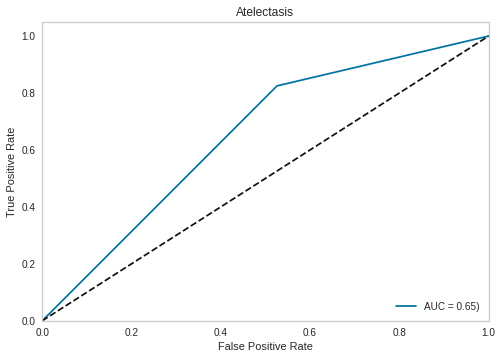

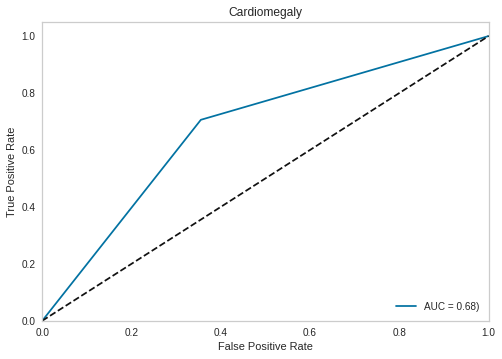

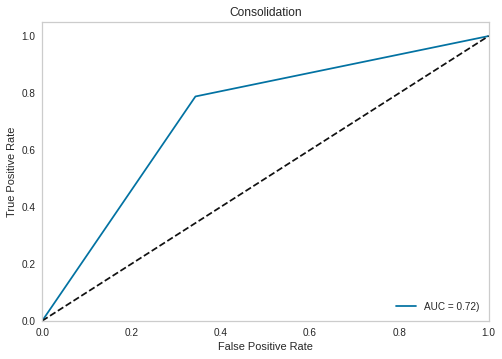

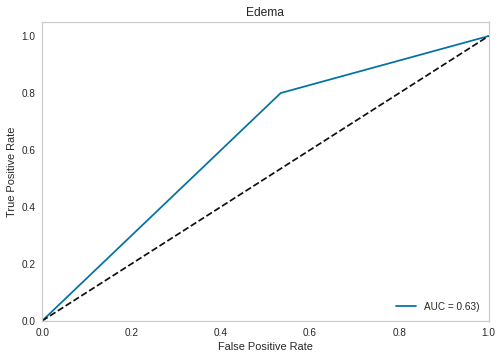

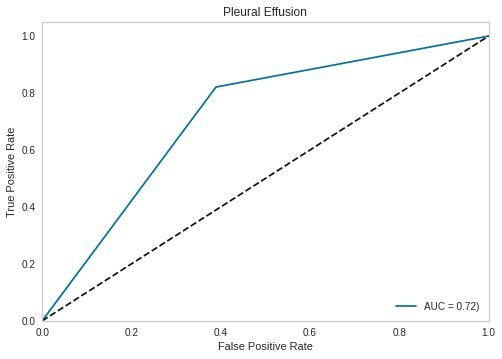

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

n_classes = 5
gnb = OneVsRestClassifier(GaussianNB())
selector = VarianceThreshold(threshold = 0.01)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('selector', selector), ('gnb', gnb)], memory = 'tmp')
ys = pipe.fit(X_train, Y_train)
y_score = pipe.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[chexpert_targets[i]], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.grid(False)
    plt.plot(fpr[i], tpr[i], label='AUC = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(chexpert_targets[i])
    plt.legend(loc="lower right")
    plt.show()

In [50]:
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.8/dist-packages/imblearn/pipeline.py:210: UserWarning: Persisting input arguments took 3.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(


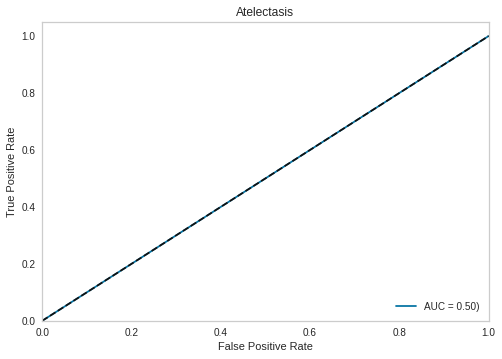

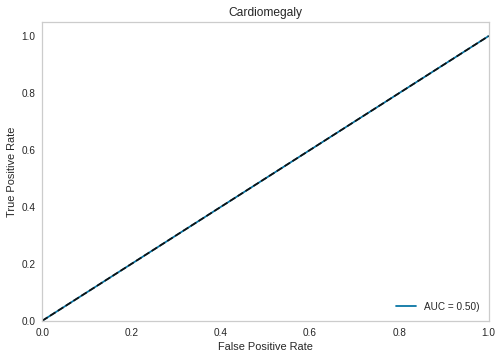

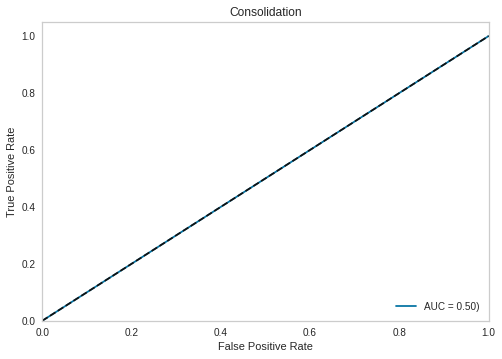

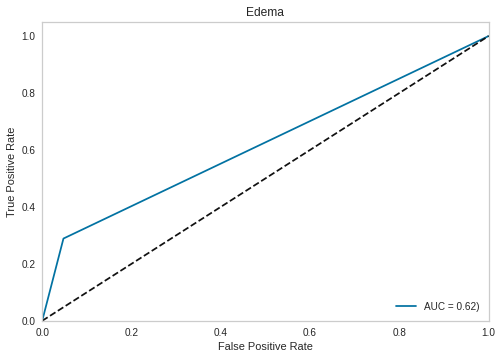

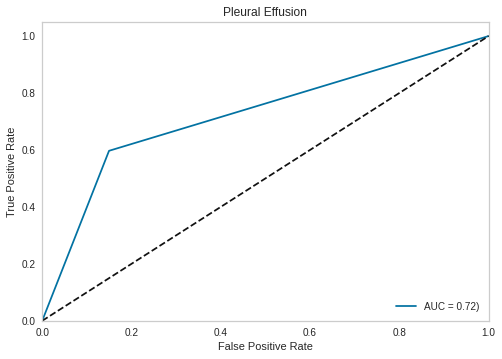

In [62]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

n_classes = 5
knn = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200, metric = 'minkowski'))
scaler = MinMaxScaler()

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('scaler', scaler), ('knn', knn)], memory = 'tmp')
ys = pipe.fit(X_train, Y_train)
y_score = pipe.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[chexpert_targets[i]], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.grid(False)
    plt.plot(fpr[i], tpr[i], label='AUC = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(chexpert_targets[i])
    plt.legend(loc="lower right")
    plt.show()

In [52]:
from sklearn.neural_network import MLPClassifier

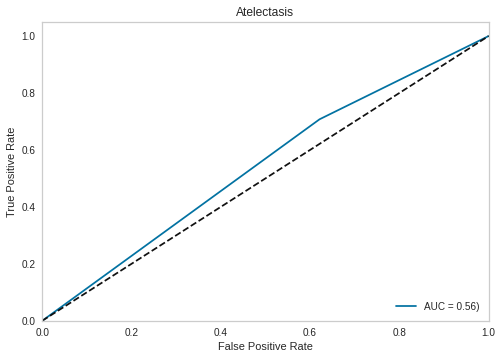

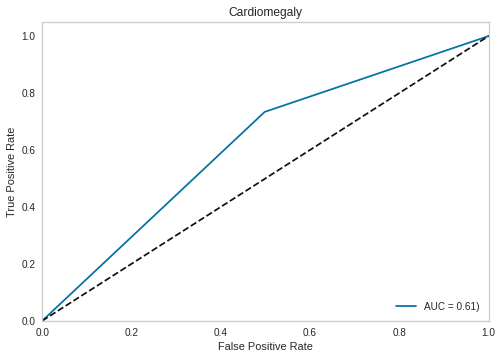

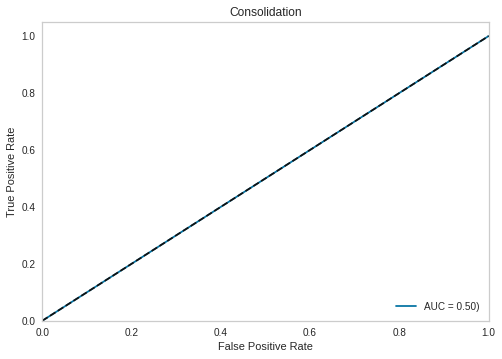

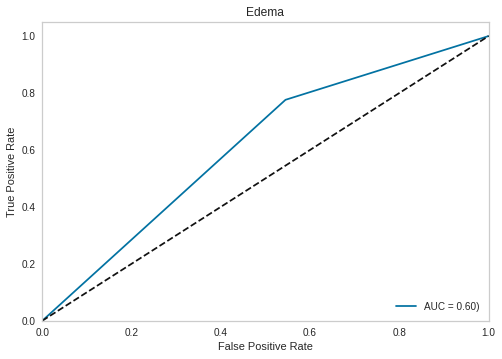

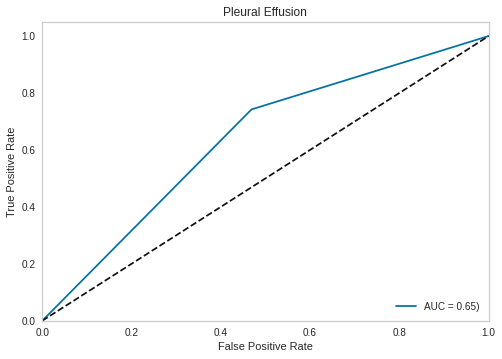

In [61]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

n_classes = 5
mlp = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes=(200), batch_size = 64, solver='adam', activation = 'relu'))
selector = VarianceThreshold(threshold = 0.01)

chexpert_targets = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

pipe = Pipeline(steps=[('selector', selector), ('mlp', mlp)], memory = 'tmp')
ys = pipe.fit(X_train, Y_train)
y_score = pipe.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[chexpert_targets[i]], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.grid(False)
    plt.plot(fpr[i], tpr[i], label='AUC = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(chexpert_targets[i])
    plt.legend(loc="lower right")
    plt.show()